### Import

In [1]:
#!git clone https://github.com/toelt-llc/ADL-Book-2nd-Ed.git
#!git clone https://github.com/Shenggan/BCCD_Dataset.git

In [2]:
# general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

# ignore warnings
import warnings
warnings.simplefilter('ignore')

import sys
sys.path.append('ADL-Book-2nd-Ed/modules/')

from read_bccd_dataset import read_data
#from style_setting import set_style

In [3]:
def build_model(arg_train_x, arg_learning_rate = 0.001):

  # one unit as network's output
  # sigmoid function as activation function
  # sequential groups a linear stack of layers into a tf.keras.Model
  # activation parameter: if you don't specify anything, no activation 
  # is applied (i.e. "linear" activation: a(x) = x).
  model = keras.Sequential([ 
    layers.Dense(1, input_shape = [len(arg_train_x.columns)], activation = 'sigmoid')
  ])

  # optimizer that implements the RMSprop algorithm
  optimizer = tf.keras.optimizers.RMSprop(learning_rate = arg_learning_rate)

  # the compile() method takes a metrics argument, which can be a list of metrics
  # loss = cross-entropy, metrics = accuracy,
  model.compile(loss = 'binary_crossentropy',
                optimizer = optimizer,
                metrics = ['binary_crossentropy','binary_accuracy'])
  
  return model

In [4]:
# Cost Function vs. Number of Iterations PLOT
def plt_hist_crossentropy(arg_hist_dict, arg_epoch=600):
    for key in arg_hist_dict:  
        plt.plot(arg_hist_dict[key]['epoch'], arg_hist_dict[key]['binary_crossentropy'],label=key)
    plt.ylabel('Cost Function (cross-entropy)')
    plt.xlabel('Number of Iterations')
    plt.legend(loc='upper right')
    plt.ylim(-5, 15)
    plt.xlim(0, arg_epoch)
    plt.axis(True)
    plt.show()

def performances_evaluation(arg_model,arg_test_x,arg_test_y,arg_test_y_bin):
    test_predictions = arg_model.predict(arg_test_x).flatten() # predict cell type with the built logistic regression model
    # The following lines compute the accuracy on the test set.

    test_predictions1 = test_predictions > 0.5
    tp = np.sum((test_predictions1 == True) & (arg_test_y_bin == 1))
    tn = np.sum((test_predictions1 == False) & (arg_test_y_bin == 0))
    accuracy_test = (tp + tn)/len(arg_test_y)
    print('The accuracy on the test set is equal to: ', int(accuracy_test*100), '%.')
    return accuracy_test

In [5]:
# This cell provides the dataset on which you will implement the logistic regression model.

# After cell's execution, you will have a pandas dataframe containing filenames,
# features (xmin, xmax, ymin, ymax), and labels (cell_type).

# You don't need to understand the implementation's details and you can simply ignore this cell.
# Simply run it with CMD+Enter (on Mac) or CTRL+Enter (Windows or Ubuntu) to
# import the necessary functions.

rd = read_data()
dataset = rd.preprocess_bccd_dataset()
dataset_reduced = dataset.loc[(dataset['cell_type'] == 'RBC') | (dataset['cell_type'] == 'WBC')]
bccd_features = dataset_reduced[['xmin', 'xmax', 'ymin', 'ymax']]
bccd_labels = dataset_reduced['cell_type']

num_observations = len(bccd_features)
print('Number of total samples: ', num_observations)

bccd_features.head()

Number of total samples:  4527


,xmin,xmax,ymin,ymax
0,260,491,177,376
1,78,184,336,435
2,63,169,237,336
3,214,320,362,461
4,414,506,352,445


In [6]:
np.random.seed(48763)
rnd = np.random.rand(len(bccd_features)) < 0.8

train_x = bccd_features[rnd] # training dataset (features)
train_y = bccd_labels[rnd] # training dataset (labels)
test_x = bccd_features[~rnd] # testing dataset (features)
test_y = bccd_labels[~rnd] # testing dataset (labels)

print('The training dataset dimensions are: ', train_x.shape)
print('The testing dataset dimensions are: ', test_x.shape)

# The following lines are need to convert the labels from RBC/WBC notation to 0/1 notation.
# This is fundamental to correctly train the net.

train_y_bin = np.zeros(len(train_y))
train_y_bin[train_y == 'WBC'] = 1

test_y_bin = np.zeros(len(test_y))
test_y_bin[test_y == 'WBC'] = 1

The training dataset dimensions are:  (3620, 4)
The testing dataset dimensions are:  (907, 4)


### Exercise 1
- Try to change the `learning_rate` parameter and see how the model's convergence changes. 
- Then try to reduce the `EPOCHS` parameter and see when the model cannot reach convergence.

In [7]:
LR=[0.001, 0.005, 0.01, 0.05]
e11_EPOCHS = 600
e11_model_dict={}
e11_hist_dict={}
e11_loss_dict={}
for lr in LR:
    model = build_model(train_x,lr)
    history = model.fit(
        train_x, train_y_bin.reshape(-1, 1),
        epochs = e11_EPOCHS, verbose = 0,
        callbacks = [tfdocs.modeling.EpochDots()])
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    e11_model_dict[lr]=model
    e11_hist_dict[lr]=hist
    e11_loss_dict[lr]=hist.iloc[-1]['loss']


Epoch: 0, binary_accuracy:0.7030,  binary_crossentropy:29.6060,  loss:29.6060,  
....................................................................................................
Epoch: 100, binary_accuracy:0.9423,  binary_crossentropy:0.2040,  loss:0.2040,  
....................................................................................................
Epoch: 200, binary_accuracy:0.9702,  binary_crossentropy:0.1113,  loss:0.1113,  
....................................................................................................
Epoch: 300, binary_accuracy:0.9754,  binary_crossentropy:0.0911,  loss:0.0911,  
....................................................................................................
Epoch: 400, binary_accuracy:0.9793,  binary_crossentropy:0.0810,  loss:0.0810,  
....................................................................................................
Epoch: 500, binary_accuracy:0.9807,  binary_crossentropy:0.0730,  loss:0.0730,  
........

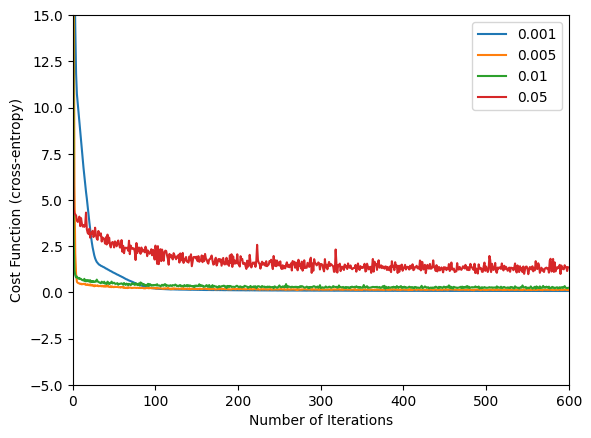

{0.001: 0.0718621015548706,
 0.005: 0.12090984731912613,
 0.01: 0.23978132009506226,
 0.05: 1.3545695543289185}

In [8]:
plt_hist_crossentropy(e11_hist_dict, e11_EPOCHS)
e11_loss_dict

In [9]:
e11_accuracy_dict={}
for key in e11_model_dict:
    print(key)
    accuracy=performances_evaluation(e11_model_dict[key],test_x,test_y,test_y_bin)
    e11_accuracy_dict[key]=accuracy
e11_accuracy_dict

0.001
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy on the test set is equal to:  97 %.
0.005
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy on the test set is equal to:  98 %.
0.01
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy on the test set is equal to:  97 %.
0.05
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy on the test set is equal to:  90 %.


{0.001: 0.9735391400220507,
 0.005: 0.9812568908489526,
 0.01: 0.9713340683572216,
 0.05: 0.9007717750826902}

In [10]:
EP=[300, 100, 50, 20]
e12_model_dict={}
e12_hist_dict={}
e12_loss_dict={}
for ep in EP:
    model = build_model(train_x)
    history = model.fit(
        train_x, train_y_bin.reshape(-1, 1),
        epochs = ep, verbose = 0,
        callbacks = [tfdocs.modeling.EpochDots()])
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    e12_model_dict[ep]=model
    e12_hist_dict[ep]=hist
    e12_loss_dict[ep]=hist.iloc[-1]['loss']


Epoch: 0, binary_accuracy:0.6746,  binary_crossentropy:13.3787,  loss:13.3787,  
....................................................................................................
Epoch: 100, binary_accuracy:0.9307,  binary_crossentropy:0.2257,  loss:0.2257,  
....................................................................................................
Epoch: 200, binary_accuracy:0.9738,  binary_crossentropy:0.0992,  loss:0.0992,  
....................................................................................................
Epoch: 0, binary_accuracy:0.0818,  binary_crossentropy:111.6997,  loss:111.6997,  
....................................................................................................
Epoch: 0, binary_accuracy:0.9155,  binary_crossentropy:30.6193,  loss:30.6193,  
..................................................
Epoch: 0, binary_accuracy:0.8787,  binary_crossentropy:11.9923,  loss:11.9923,  
....................

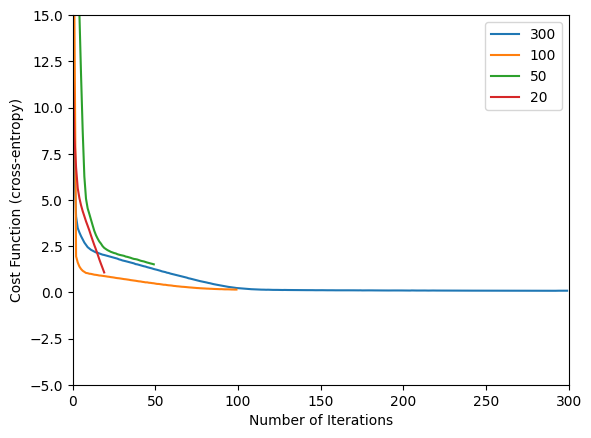

{300: 0.08761098980903625,
 100: 0.14987216889858246,
 50: 1.5156689882278442,
 20: 1.0760456323623657}

In [11]:
plt_hist_crossentropy(e12_hist_dict, 300)
e12_loss_dict

In [12]:
e12_accuracy_dict={}
for key in e12_model_dict:
    print(key)
    accuracy=performances_evaluation(e12_model_dict[key],test_x,test_y,test_y_bin)
    e12_accuracy_dict[key]=accuracy
e12_accuracy_dict

300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy on the test set is equal to:  96 %.
100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy on the test set is equal to:  96 %.
50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy on the test set is equal to:  80 %.
20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy on the test set is equal to:  84 %.


{300: 0.960308710033076,
 100: 0.9614112458654906,
 50: 0.802646085997795,
 20: 0.8478500551267916}

### Exercise 2
- Try to see how model's results change based on the training dataset's size (reduce it and use different sizes comparing the final results).

In [13]:
len(train_x)

3620

In [14]:
np.random.seed(48763)

RT=[0.763, 0.48763, 0.25, 0.1]
e2_EPOCHS = 1000
e2_model_dict={}
e2_hist_dict={}
e2_loss_dict={}
for rt in RT:
    rnd = np.random.rand(len(train_x)) < rt
    model = build_model(train_x[rnd])
    history = model.fit(
        train_x[rnd], train_y_bin.reshape(-1, 1)[rnd],
        epochs = e2_EPOCHS, verbose = 0,
        callbacks = [tfdocs.modeling.EpochDots()])
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    e2_model_dict[len(train_x[rnd])]=model
    e2_hist_dict[len(train_x[rnd])]=hist
    e2_loss_dict[len(train_x[rnd])]=hist.iloc[-1]['loss']


Epoch: 0, binary_accuracy:0.7967,  binary_crossentropy:23.6427,  loss:23.6427,  
....................................................................................................
Epoch: 100, binary_accuracy:0.9525,  binary_crossentropy:0.1654,  loss:0.1654,  
....................................................................................................
Epoch: 200, binary_accuracy:0.9703,  binary_crossentropy:0.1060,  loss:0.1060,  
....................................................................................................
Epoch: 300, binary_accuracy:0.9775,  binary_crossentropy:0.0865,  loss:0.0865,  
....................................................................................................
Epoch: 400, binary_accuracy:0.9786,  binary_crossentropy:0.0777,  loss:0.0777,  
....................................................................................................
Epoch: 500, binary_accuracy:0.9804,  binary_crossentropy:0.0690,  loss:0.0690,  
........

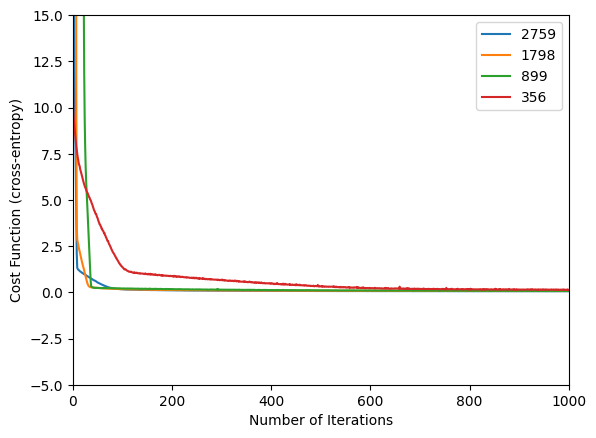

{2759: 0.0585133358836174,
 1798: 0.07139386236667633,
 899: 0.07455632835626602,
 356: 0.13924825191497803}

In [15]:
plt_hist_crossentropy(e2_hist_dict, e2_EPOCHS)
e2_loss_dict

In [16]:
e2_accuracy_dict={}
for key in e2_model_dict:
    print(key)
    accuracy=performances_evaluation(e2_model_dict[key],test_x,test_y,test_y_bin)
    e2_accuracy_dict[key]=accuracy
e2_accuracy_dict

2759
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The accuracy on the test set is equal to:  98 %.
1798
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy on the test set is equal to:  98 %.
899
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy on the test set is equal to:  97 %.
356
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy on the test set is equal to:  96 %.


{2759: 0.9823594266813671,
 1798: 0.9823594266813671,
 899: 0.9724366041896362,
 356: 0.960308710033076}